In [25]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy import stats
import seaborn as sns

plt.style.use('seaborn-white')

illusion_variations = {
    0: {"originalID": 0, "patches" : 40, 'shiftfactor': 4}, 
    1: {"originalID": 1, "patches" : 40, 'shiftfactor': 8}, 
    2: {"originalID": 2, "patches" : 72, 'shiftfactor': 4}, 
    3: {"originalID": 3, "patches" : 72, 'shiftfactor': 8}, 
    4: {"originalID": 4, "patches" : 56, 'shiftfactor': 4}, 
    5: {"originalID": 5, "patches" : 56, 'shiftfactor': 8}, 
    6: {"originalID": 7, "patches" : 88, 'shiftfactor': 4}, 
    7: {"originalID": 6, "patches" : 88, 'shiftfactor': 8}, 
    8: {"originalID": 8, "patches" : 104, 'shiftfactor': 4},
    9: {"originalID": 9, "patches" : 104, 'shiftfactor': 8} 
}

In [26]:
#%% Create one data table with ids and results
path = '../Results/Data/experiment/'
fragments = []
for file in os.listdir(path):
  fragment = pd.read_json(path + file)
  userid = file.split('.')[0] 
  fragment['userID'] = pd.Series([userid for i in range(len(fragment))])
  fragments.append(fragment)

df = pd.concat(fragments, ignore_index=True)
dfp = df[df.illusionName == 'Popple Illusion'].copy()

In [27]:
#%% Correct distortion to be in % of radius as it is in our paper
dfp['distortion'] = dfp['distortion'] * 0.2 - 0.1

In [28]:
#%% Swap ids to correct shiftfactor order (mistake during experiment design)
mask_7 = dfp.variationID == 7
mask_6 = dfp.variationID == 6
dfp.loc[mask_7, 'variationID'] = 6
dfp.loc[mask_6 , 'variationID'] = 7

In [29]:
#%% Print initial dataFrame
dfp

,distortion,illusionID,illusionName,illusionOrder,inverted,sliderEnd,sliderInit,sliderStart,variationID,variationOrder,userID
94,0.001745,10,Popple Illusion,10,5,0.848832,0.723618,0.007723,2,0,03e72732-e217-4338-b072-c6602a84b043
95,-0.010142,10,Popple Illusion,10,5,0.902329,0.273216,0.129291,4,1,03e72732-e217-4338-b072-c6602a84b043
96,-0.019369,10,Popple Illusion,10,5,0.819773,0.854498,0.193156,1,2,03e72732-e217-4338-b072-c6602a84b043
97,-0.012411,10,Popple Illusion,10,5,0.865923,0.638496,0.087947,0,3,03e72732-e217-4338-b072-c6602a84b043
98,-0.010172,10,Popple Illusion,10,5,0.849193,0.483255,0.170139,6,4,03e72732-e217-4338-b072-c6602a84b043
99,-0.004973,10,Popple Illusion,10,5,0.931677,0.408245,0.018137,8,5,03e72732-e217-4338-b072-c6602a84b043
100,-0.013561,10,Popple Illusion,10,5,0.804496,0.385831,0.048193,5,6,03e72732-e217-4338-b072-c6602a84b043
101,-0.020413,10,Popple Illusion,10,5,0.830687,0.436272,0.030935,7,7,03e72732-e217-4338-b072-c6602a84b043
102,-0.013830,10,Popple Illusion,10,5,0.887456,0.344740,0.176848,3,8,03e72732-e217-4338-b072-c6602a84b043
103,-0.008656,10,Popple Illusion,10,5,0.861397,0.516147,0.017721,9,9,03e72732-e217-4338-b072-c6602a84b043


In [30]:
#%% Boxplot preparation
fragments = []
for key, val in illusion_variations.items():
    mask = dfp.variationID == key
    fragment = dfp[mask][['userID', 'distortion', 'inverted']].set_index(['userID'])
    fragment.columns = [
      "D-p{}s{}".format(val['patches'], val['shiftfactor']),
      "I-p{}s{}".format(val['patches'], val['shiftfactor'])
    ]
    fragments.append(fragment)

# variation-wise dataset
df_vw = reduce(lambda l, r: l.join(r), fragments[1:], fragments[0])

In [31]:
#%% add demographics to data
path = '../Results/Data/questionnaire/'
for user_id in df_vw.index:
  questionnaire = pd.read_json('{}{}.json'.format(path, user_id), typ='series')
  df_vw.loc[user_id, 'vimp'] = questionnaire['Do you have any visual impairments?']
  df_vw.loc[user_id, 'vimp_type'] = questionnaire['If yes, what and when did you experience these problems?']
  df_vw.loc[user_id, 'other_exp'] = questionnaire['Did you ever participate in an experiment related to perceptual illusions?']
  df_vw.loc[user_id, 'age'] = questionnaire['Age']
  df_vw.loc[user_id, 'gender'] = questionnaire['Gender']

In [32]:
#%% D means distortion I means user impresssion p is the patch size and s the shift factor
df_vw

,D-p40s4,I-p40s4,D-p40s8,I-p40s8,D-p72s4,I-p72s4,D-p72s8,I-p72s8,D-p56s4,I-p56s4,...,I-p88s8,D-p104s4,I-p104s4,D-p104s8,I-p104s8,vimp,vimp_type,other_exp,age,gender
userID,,,,,,,,,,,,,,,,,,,,,
03e72732-e217-4338-b072-c6602a84b043,-0.012411,5,-0.019369,5,0.001745,5,-0.013830,5,-0.010142,5,...,5,-0.004973,5,-0.008656,5,No,,No,22.0,male
0fe9d91b-0453-4306-bcf9-f7ccccaa0d07,-0.011776,5,-0.024078,4,-0.006510,4,-0.015899,5,-0.005084,4,...,5,-0.005554,5,-0.011889,5,No,,No,23.0,male
17507437-66fb-45f4-b67e-fef21f85211d,-0.019266,4,-0.020534,4,-0.011275,4,-0.019301,4,-0.003103,5,...,4,-0.011182,4,-0.013425,4,No,,No,22.0,male
18bc1298-a0ef-424a-b39e-e59df7dc4a61,-0.022699,5,-0.019132,3,-0.012274,5,-0.022693,5,-0.004126,5,...,5,-0.012145,4,-0.017034,5,No,,No,22.0,female
19ebc6be-3253-44a5-91fd-ddd8e754e9d9,-0.017013,5,-0.028940,5,-0.011891,5,-0.020353,5,-0.009589,5,...,5,-0.004424,5,-0.021959,5,No,,No,22.0,male
1a27c8a8-ea61-433e-80da-476437c53274,-0.021334,2,-0.022577,2,-0.007115,4,-0.026298,3,-0.006417,2,...,3,-0.009060,3,-0.021922,2,No,,Yes,23.0,male
1c5a396b-86a4-4a33-a8b8-f629c6c95c79,-0.011924,5,-0.024631,5,-0.009681,5,-0.012871,5,-0.009090,5,...,5,-0.011732,5,-0.016758,5,No,,No,21.0,male
1ffb0cc1-ab26-4e79-b0fd-5c204b8d4851,-0.008724,5,-0.010605,5,-0.005176,5,-0.004171,5,-0.003171,5,...,5,-0.001057,5,-0.015410,5,No,-,No,23.0,male
20d58834-bc22-45e7-8059-26732c3d0b4e,-0.002239,5,-0.025041,5,0.001587,5,-0.012008,5,-0.002206,5,...,5,-0.009075,5,-0.008133,5,No,,No,22.0,male


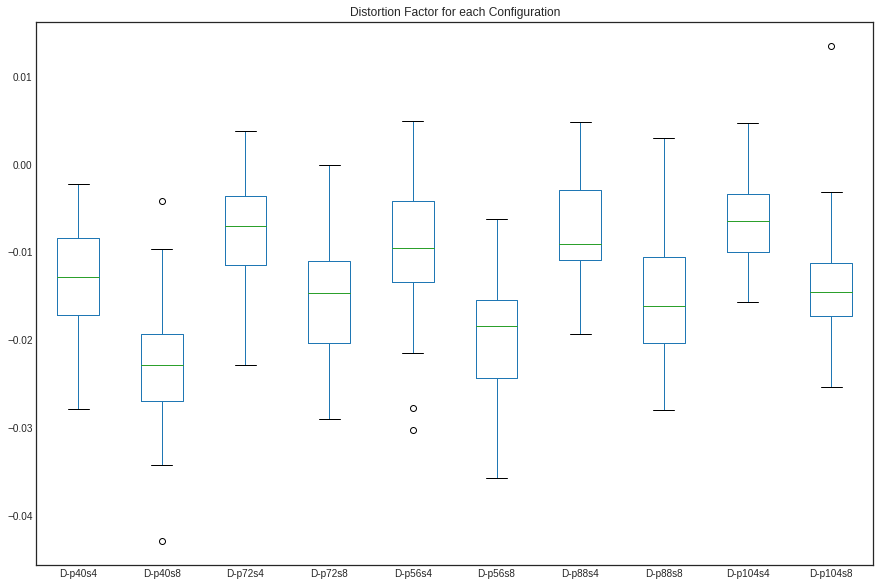

In [33]:
#%% box plot of distortions
fig, ax = plt.subplots(1, 1, figsize=(15,10))
df_vw.filter(regex='D-*').boxplot(
        grid=False,
        ax=ax
      )
ax.set_title("Distortion Factor for each Configuration")
fig.savefig('../Plots/boxes')

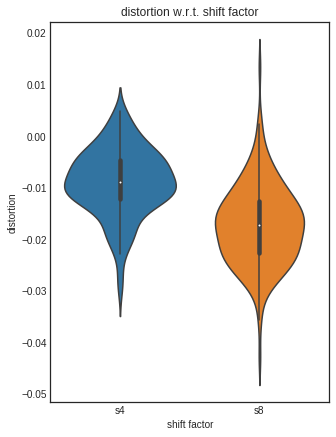

In [34]:
#%% Aggregated violin plots
fig, ax = plt.subplots(1, 1, figsize=(5,7))
bp_aggregated = pd.DataFrame([
    df_vw.filter(regex='D-.*s4').melt()['value'],
    df_vw.filter(regex='D-.*s8').melt()['value']
  ]).transpose()
bp_aggregated.columns = ['s4', 's8']
# bp_aggregated.boxplot(grid=False, ax=ax)
sns.violinplot(data=bp_aggregated)
ax.set_title("distortion w.r.t. shift factor")
ax.set_xlabel('shift factor')
ax.set_ylabel('distortion')
fig.savefig('../Plots/violin_plot_shift_factor.png')


In [35]:
bp_aggregated

,s4,s8
0,-0.012411,-0.019369
1,-0.011776,-0.024078
2,-0.019266,-0.020534
3,-0.022699,-0.019132
4,-0.017013,-0.028940
5,-0.021334,-0.022577
6,-0.011924,-0.024631
7,-0.008724,-0.010605
8,-0.002239,-0.025041
9,-0.027923,-0.042838


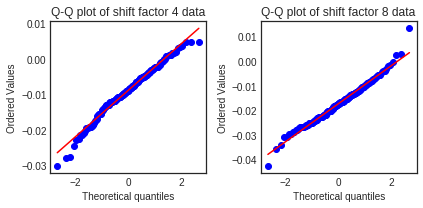

In [36]:
#%%
fig, ax = plt.subplots(1, 2, figsize=(6,3))
stats.probplot(bp_aggregated['s4'], plot=ax[0])
stats.probplot(bp_aggregated['s8'], plot=ax[1])
ax[0].set_title("Q-Q plot of shift factor 4 data")
ax[1].set_title("Q-Q plot of shift factor 8 data")
fig.tight_layout()
fig.savefig('../Plots/qqplot.png')

In [37]:
#%% Perform a shapiro / kstest test on shift factor data
print(stats.shapiro(bp_aggregated['s4']))
print(stats.shapiro(bp_aggregated['s8']))
print(stats.kstest(bp_aggregated['s4'], 'norm'))
print(stats.kstest(bp_aggregated['s8'], 'norm'))

print(stats.ttest_ind(bp_aggregated['s4'], bp_aggregated['s8']))
print(bp_aggregated.kurtosis())

print(stats.ttest_1samp(bp_aggregated, 0.0))


(0.984150230884552, 0.03460630774497986)
(0.9874945282936096, 0.10134682804346085)
KstestResult(statistic=0.49806506317304455, pvalue=6.136000876980224e-43)
KstestResult(statistic=0.4946620955779788, pvalue=2.5457489330960623e-42)
Ttest_indResult(statistic=11.16055872310228, pvalue=4.146598850487407e-25)
s4    0.468525
s8    1.167498
dtype: float64
Ttest_1sampResult(statistic=array([-18.55027931, -30.29376546]), pvalue=array([5.40870651e-44, 2.00042918e-73]))


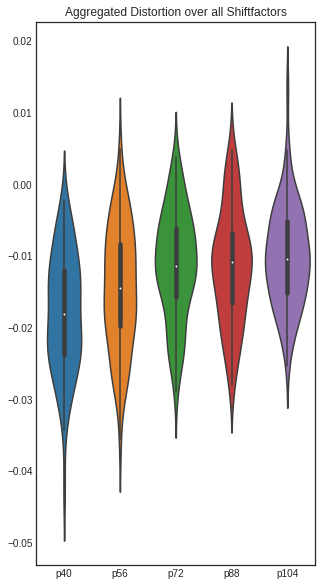

In [38]:
#%% Aggregated violin plots
fig, ax = plt.subplots(1, 1, figsize=(5,10))
bp_patches = pd.DataFrame([
    df_vw.filter(regex='D-p40*').melt()['value'],
    df_vw.filter(regex='D-p56*').melt()['value'],
    df_vw.filter(regex='D-p72*').melt()['value'],
    df_vw.filter(regex='D-p88*').melt()['value'],
    df_vw.filter(regex='D-p104*').melt()['value']
  ]).transpose()
bp_patches.columns = ['p40', 'p56', 'p72', 'p88', 'p104']
# bp_aggregated.boxplot(grid=False, ax=ax)
sns.violinplot(data=bp_patches)
ax.set_title("Aggregated Distortion over all Shiftfactors")
fig.savefig('../Plots/aggregated_boxes_size')


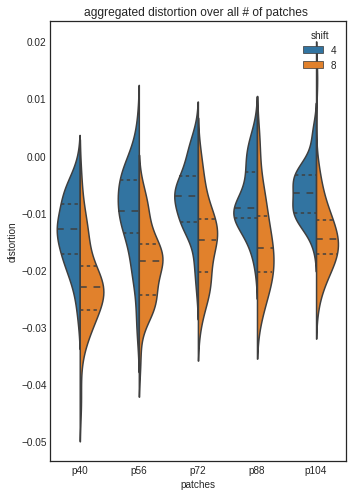

In [39]:
#%%
columns = ['p40', 'p56', 'p72', 'p88', 'p104']

s4 = df_vw.filter(regex='D-.*s4').copy().melt(
    var_name='patches', 
    value_name='distortion'
)
s8 = df_vw.filter(regex='D-.*s8').copy().melt(
    var_name='patches', 
    value_name='distortion'
)

s4['patches'] = s4['patches'].apply(lambda v: v[:-2])
s8['patches'] = s8['patches'].apply(lambda v: v[:-2])
s4['shift'] = 4 
s8['shift'] = 8 
bp_patches_long = pd.concat(
  [s4, s8]
)

bp_patches_long['patches'] = bp_patches_long['patches'].apply(lambda v: v[2:])

fig, ax = plt.subplots(1, 1, figsize=(5,7))

# bp_aggregated.boxplot(grid=False, ax=ax)
sns.violinplot(x='patches', y='distortion',
  data=bp_patches_long,
  split=True,
  order=[c for c in columns],
  inner='quartile',
  hue='shift')
ax.set_title("aggregated distortion over all # of patches ")
fig.tight_layout()
fig.savefig('../Plots/violin_plot_patch_size.png')


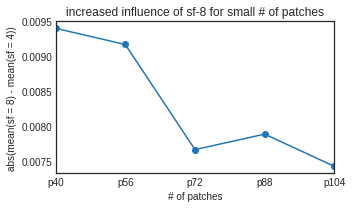

In [40]:
#%%
fig, ax = plt.subplots(1, 1, figsize=(5,3))
d_mean = []
for c in columns:
  p4 = bp_patches_long[
    (bp_patches_long['patches'] == '{}'.format(c)) &
    (bp_patches_long['shift'] == 4)
  ]
  p8 = bp_patches_long[
    (bp_patches_long['patches'] == '{}'.format(c)) &
    (bp_patches_long['shift'] == 8)
  ]
  d_mean.append([
    p4['distortion'].mean(),
    p8['distortion'].mean()]) 
  
d_mean_df = pd.DataFrame(d_mean)
d_mean_df = d_mean_df.set_index(pd.Index(columns))
d_mean_df.columns = [4,8]
ax.set_title('increased influence of sf-8 for small # of patches')
(np.abs(d_mean_df[8] - d_mean_df[4])).plot(ax=ax, marker='o')
ax.set_ylabel('abs(mean(sf = 8) - mean(sf = 4))')
ax.set_xlabel('# of patches')
fig.tight_layout()
fig.savefig('../Plots/means_diverge.png')

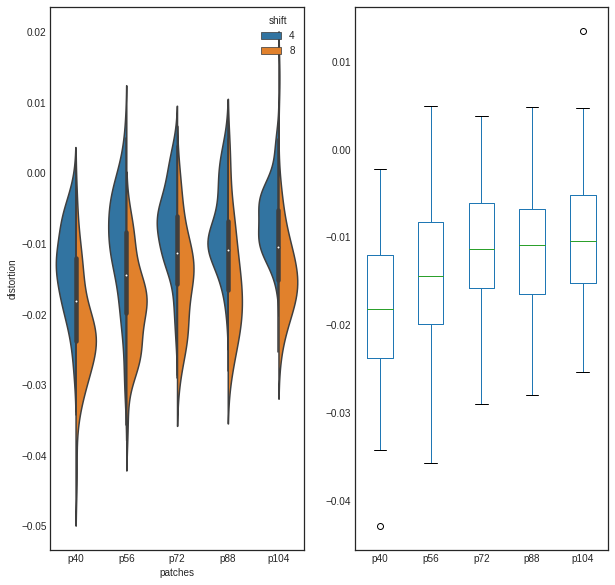

In [41]:
#%% Compare violin plot with old box plot representation to make sure the new violin plots are appropriate
fig, axes = plt.subplots(1, 2, figsize=(10,10))

ax = axes[0]
sns.violinplot(x='patches', y='distortion',
    data=bp_patches_long,
    split=True,
    ax=ax,
    order=['p40', 'p56', 'p72', 'p88', 'p104'],
    hue='shift'
  )

ax = axes[1]
bp_patches.boxplot(grid=False, ax=ax)

(0.9824340343475342, 0.393971711397171)
KstestResult(statistic=0.5008932671908892, pvalue=1.068691787188159e-17)
(0.987243115901947, 0.665987491607666)
KstestResult(statistic=0.49806506317304455, pvalue=1.7223656749384825e-17)
(0.9817945957183838, 0.36430254578590393)
KstestResult(statistic=0.49851353542959653, pvalue=1.597202816493638e-17)
(0.9844496846199036, 0.4987621009349823)
KstestResult(statistic=0.4981141114688784, pvalue=1.7082198992951333e-17)
(0.9823604822158813, 0.3904671370983124)
KstestResult(statistic=0.4946620955779788, pvalue=3.0443517120105705e-17)
Ttest_1sampResult(statistic=array([-18.91136643, -14.67879057, -12.91467256, -12.55634261,
       -12.62689372]), pvalue=array([7.48289002e-30, 1.77006626e-23, 1.55831321e-20, 6.47813747e-20,
       4.88741816e-20]))


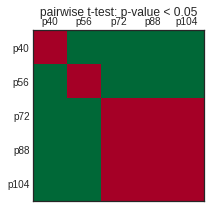

In [42]:
#%% Stat analysis of # patches
p_vals = np.zeros((5,5))
for id_x, col in enumerate(bp_patches):
  print(stats.shapiro(bp_patches[col]))
  print(stats.kstest(bp_patches[col], 'norm'))
  # stats.probplot(bp_aggregated[col], plot=ax)
  for id_y, row in enumerate(bp_patches):
    p_vals[id_y, id_x] = stats.ttest_ind(
      bp_patches[col],
      bp_patches[row]
    ).pvalue

print(stats.ttest_1samp(bp_patches, 0.0))

p_val_df = pd.DataFrame(p_vals)
p_val_df = p_val_df.set_index(pd.Index(bp_patches.columns))
p_val_df.columns = bp_patches.columns

fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot = ax.matshow((p_val_df < 0.05).astype(int), cmap='RdYlGn')
ax.set_title('pairwise t-test: p-value < 0.05')
ax.set_xticklabels(bp_patches.columns)
ax.set_yticklabels(bp_patches.columns)
ax.set_xticks(np.arange(len(bp_patches.columns)))
ax.set_yticks(np.arange(len(bp_patches.columns)))
ax.set_facecolor('white')
fig.tight_layout()
fig.savefig('../Plots/ttest_patch_size_matrix.png')


4.6891891891891895

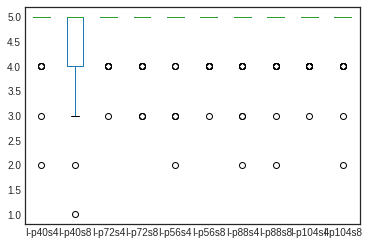

In [43]:
#%% box plot of distortions (doesnt make muc)
df_vw.filter(regex='I-*').boxplot(grid=False)
df_vw.filter(regex='I-*').mean().mean()


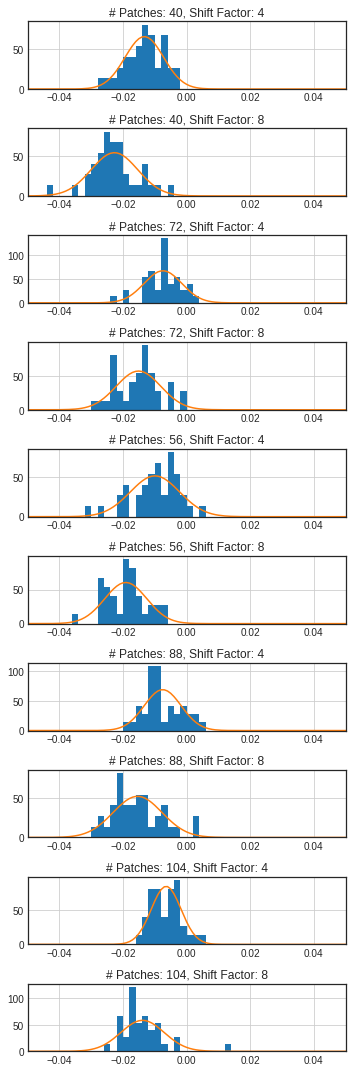

In [44]:
#%% Recreate Multi Histogram
fig, axes = plt.subplots(10,1, figsize=(5, 15))
for id_ax, ax in enumerate(axes.flatten()):
  var = illusion_variations[id_ax]
  ax.set_title('# Patches: {}, Shift Factor: {}'.format(var["patches"], var['shiftfactor']))
  data = dfp[dfp.variationID == id_ax].distortion
  data.hist(ax=ax, range=(-0.1,0.1), bins=100, density=True)
  r = np.arange(-0.1, 0.1, 0.001)
  ax.plot(r, stats.norm.pdf(r, data.mean(), data.std()))
  ax.set_xlim(-0.05, 0.05)
fig.tight_layout()
fig.savefig('../Plots/multi-histogram.png')